<a href="https://colab.research.google.com/github/jjayli/my-data-science/blob/main/notebooks/EC_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 고객 행동 패턴 분석 및 RFM 기반 세분화

온라인 쇼핑몰 고객의 구매 이력을 바탕으로 고객의 가치를 평가하고 **행동 패턴을 파악**하는 것을 목적
단순한 매출 집계 뿐만 아니라 행동 데이터에 기반해 분류함으로써 타겟 마케팅 전략 수립의 근거를 마련

데이터 출처: [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/352/online+retail)

데이터 구조: 2010년 12월 ~ 2011년 12월 사이의 영국 기반 전자상거래 거래 내역

변수:

InvoiceNo: 송장 번호

StockCode: 제품 코드

Description: 제품 설명

Quantity: 구매 수량

InvoiceDate: 결제 일시

UnitPrice: 단가

CustomerID: 고객 고유 ID

Country: 고객 거주 국가

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

**1. 데이터 로딩 및 구조 파악**

In [10]:
df = pd.read_excel('/content/Online Retail.xlsx')
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


**2. 수량 및 단가 이상치 탐색**

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


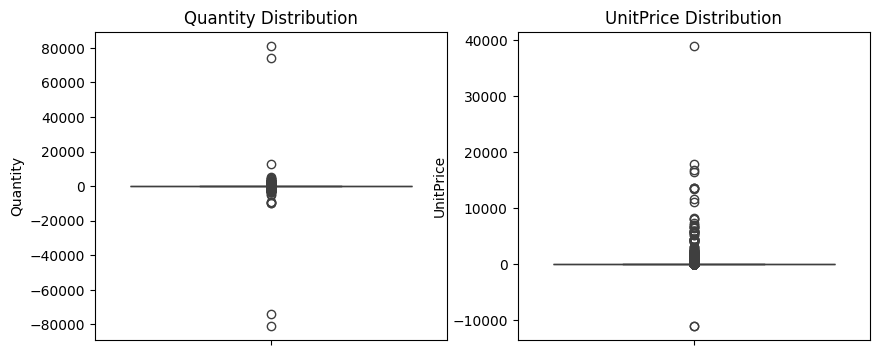

In [11]:
# 기술 통계량 확인
display(df.describe())

# 이상치 시각화
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['Quantity'])
plt.title('Quantity Distribution')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['UnitPrice'])
plt.title('UnitPrice Distribution')
plt.show()

**3. 국가별 매출 비중**

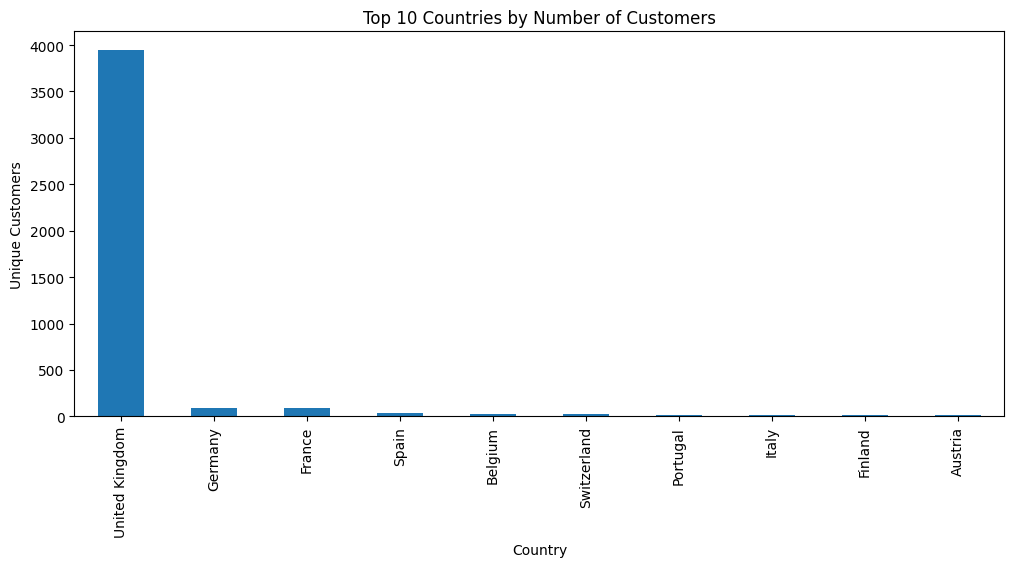

In [12]:
#국가별로 고객 분포 확인

top_countries = df.groupby('Country')['CustomerID'].nunique().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 5))
top_countries.plot(kind='bar')
plt.title('Top 10 Countries by Number of Customers')
plt.ylabel('Unique Customers')
plt.show()

In [13]:
# CustomerID 결측치 제거
df = df.dropna(subset=['CustomerID'])

# 반품 데이터 분리 및 제거 (InvoiceNo가 C로 시작하는 경우)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

In [14]:
df['TotalSum'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

**4. RFM 기반 고객 세분화**

Recency: 가장 최근 구매일로부터 며칠 경과
Frequency: 얼마나 자주 구매
Monetary: 토탈 구매 금액

In [15]:
# 분석 기준일 설정
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'
})

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSum': 'Monetary'
}, inplace=True)

In [16]:
# 로그 변환
rfm_log = np.log1p(rfm)

**5. K-Means 클러스터링**
: 단순 등급 부여 대신 K-Means 알고리즘을 사용하여 데이터 기반의 군집을 생성

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

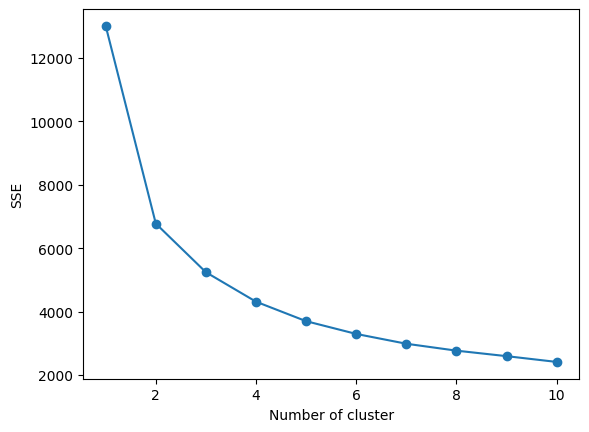

In [18]:
# 표준화
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# 최적의 K 개수 탐색
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_

plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [19]:
# K=4로 설정 및 클러스터링
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [23]:
rfm.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,326,1,77183.60,1
12347.0,2,182,4310.00,2
12348.0,75,31,1797.24,1
12349.0,19,73,1757.55,1
12350.0,310,17,334.40,3


In [24]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

# 컬럼명 정리
cluster_summary.columns = ['Recency_Mean', 'Frequency_Mean', 'Monetary_Mean', 'Count']
cluster_summary['Coverage(%)'] = (cluster_summary['Count'] / cluster_summary['Count'].sum() * 100).round(1)

# 비즈니스 페르소나 부여 (예시)
persona = {
    0: "VVIP (High Value)",
    1: "New Customers (Potential)",
    2: "At Risk (Former VIP)",
    3: "Lost/Low Value"
}
cluster_summary['Persona'] = cluster_summary.index.map(persona)

display(cluster_summary.sort_values('Monetary_Mean', ascending=False))

,Recency_Mean,Frequency_Mean,Monetary_Mean,Count,Coverage(%),Persona
Cluster,,,,,,
2,12.8,281.4,6996.5,874,20.1,At Risk (Former VIP)
1,94.3,80.1,1515.6,1241,28.6,New Customers (Potential)
0,20.4,37.1,588.0,864,19.9,VVIP (High Value)
3,188.0,15.0,299.9,1359,31.3,Lost/Low Value


: 4개의 그룹으로 분류

- Cluster0 (VIP): 최근성, 빈도, 금액 모두 최상위. 유지 전략.
- Cluster1 (신규 고객): 최근 구매했으나 빈도와 금액이 낮음, 재구매 유도 필요.
- Cluster2 (이탈 위기): 과거 구매액은 크지만 최근 방문이 없음, 리인게이지먼트 캠페인 대상.
- Cluster3 (가치 낮은 고객): 모든 지표가 낮음.

**추가 분석 **
**코호트 분석**

In [26]:
# 1. 첫 구매월 추출
df['OrderMonth'] = df['InvoiceDate'].dt.to_period('M')
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

# 2. 코호트 인덱스 계산
df['CohortIndex'] = (df['OrderMonth'].view('int64') - df['CohortMonth'].view('int64'))

# 3. 코호트별 유지 사용자 수 계산
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# 4. 백분율
cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0)

/tmp/ipython-input-609812531.py:6: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df['CohortIndex'] = (df['OrderMonth'].view('int64') - df['CohortMonth'].view('int64'))
/tmp/ipython-input-609812531.py:6: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df['CohortIndex'] = (df['OrderMonth'].view('int64') - df['CohortMonth'].view('int64'))


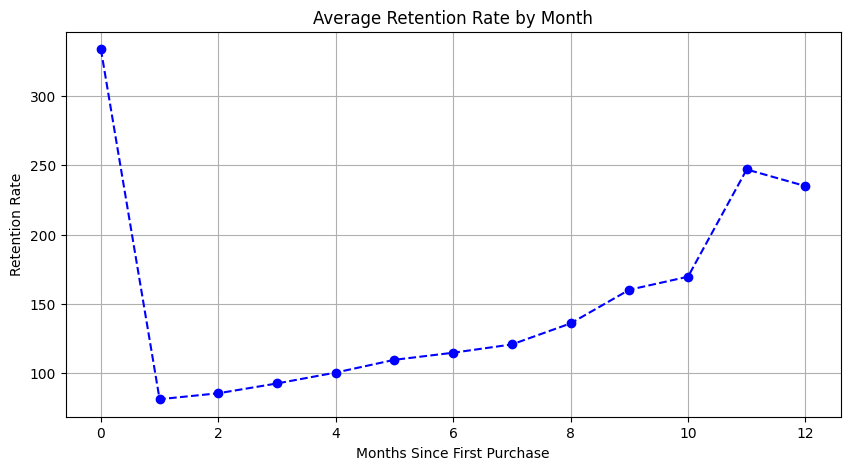

In [30]:
# 첫 번째 달(100%)을 제외한 평균 유지율 계산
average_retention = cohort_pivot.mean()

plt.figure(figsize=(10, 5))
plt.plot(average_retention.index, average_retention.values, marker='o', linestyle='--', color='b')
plt.title('Average Retention Rate by Month')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Retention Rate')
plt.grid(True)
plt.show()